In [14]:
import pandas as pd 
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv('/Users/mariakatibi/Desktop/transParam.csv', delimiter=';')

In [16]:
print(df.columns)

Index(['Source', 'Destination', 'Demand', 'Cost '], dtype='object')


In [17]:
def northwest_corner(data):
    supply = data.groupby('Source')['Demand'].sum()
    demand = data.groupby('Destination')['Demand'].sum()
    
    num_sources = len(supply)
    num_destinations = len(demand)
    transportation_matrix = np.zeros((num_sources, num_destinations))
    
    i = 0
    j = 0
    while i < num_sources and j < num_destinations:
        transportation_matrix[i, j] = min(supply[i], demand[j])
        if supply[i] < demand[j]:
            demand[j] -= supply[i]
            i += 1
        elif supply[i] > demand[j]:
            supply[i] -= demand[j]
            j += 1
        else:
            i += 1
            j += 1
    
    return transportation_matrix


In [18]:
def minimum_cost(data):
    data_copy = data.copy()
    
    num_sources = len(data_copy['Source'].unique())
    num_destinations = len(data_copy['Destination'].unique())
    cost_matrix = np.zeros((num_sources, num_destinations))
    
    for i, source in enumerate(data_copy['Source'].unique()):
        for j, destination in enumerate(data_copy['Destination'].unique()):
            cost_matrix[i, j] = data_copy[(data_copy['Source'] == source) & (data_copy['Destination'] == destination)]['Cost '].values[0]
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    transportation_matrix = np.zeros_like(cost_matrix)
    
    for i, j in zip(row_ind, col_ind):
        transportation_matrix[i, j] = min(data_copy[(data_copy['Source'] == data_copy['Source'].unique()[i]) & 
                                                     (data_copy['Destination'] == data_copy['Destination'].unique()[j])]['Demand'].values[0],
                                          data_copy[(data_copy['Source'] == data_copy['Source'].unique()[i]) & 
                                                     (data_copy['Destination'] == data_copy['Destination'].unique()[j])]['Demand'].values[0])
    
    return transportation_matrix

In [19]:
minimum_cost_matrix = minimum_cost(df)
print("The minimum cost matrix : ")
print(minimum_cost_matrix)

The minimum cost matrix : 
[[  0.  50.]
 [150.   0.]]


In [20]:
initial_solution = northwest_corner(df)
print("Initial Feasible Solution using Northwest corner rule:")
print(initial_solution)

Initial Feasible Solution using Northwest corner rule:
[[150.   0.]
 [100. 150.]]


In [21]:
def solve_transportation_problem(cost_matrix, supply_vector, demand_vector):
    c = cost_matrix.flatten()
    
    A_eq = []
    for i in range(cost_matrix.shape[0]):
        for j in range(cost_matrix.shape[1]):
            row = [0] * (cost_matrix.shape[0] * cost_matrix.shape[1])
            row[i * cost_matrix.shape[1] + j] = 1
            A_eq.append(row)
    b_eq = np.concatenate((supply_vector, demand_vector))
    
    bounds = [(0, None)] * len(c)
    
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    optimal_solution = np.reshape(res.x, cost_matrix.shape)
    
    return optimal_solution, res.fun

In [22]:
supply_vector = df.groupby('Source')['Demand'].sum().values
demand_vector = df.groupby('Destination')['Demand'].sum().values

In [23]:
print("Supply Vector:", supply_vector)
print("Demand Vector:", demand_vector)

Supply Vector: [150 250]
Demand Vector: [250 150]


In [24]:
optimal_solution, total_cost = solve_transportation_problem(minimum_cost_matrix, supply_vector, demand_vector)
optimal_solution1, total_cost1 = solve_transportation_problem(initial_solution, supply_vector, demand_vector)

print("Optimal Transportation Plan:")
print(optimal_solution)
print(optimal_solution1)
print("Total Cost:", total_cost)
print("Total Cost:", total_cost1)

Optimal Transportation Plan:
[[150. 250.]
 [250. 150.]]
[[150. 250.]
 [250. 150.]]
Total Cost: 50000.0
Total Cost: 70000.0


In [25]:
def plot_transportation_plan(optimal_solution):
    plt.figure(figsize=(8, 6))
    plt.imshow(optimal_solution, cmap='viridis', interpolation='nearest')

    plt.xlabel('Destinations')
    plt.ylabel('Sources')
    
    plt.title('Transportation Plan')
    
    plt.colorbar(label='Units transported')
    
    plt.grid(True, color='gray')
    
    plt.xticks(np.arange(optimal_solution.shape[1]), labels=['X', 'Y'])
    plt.yticks(np.arange(optimal_solution.shape[0]), labels=['A', 'B'])
    
    plt.show()

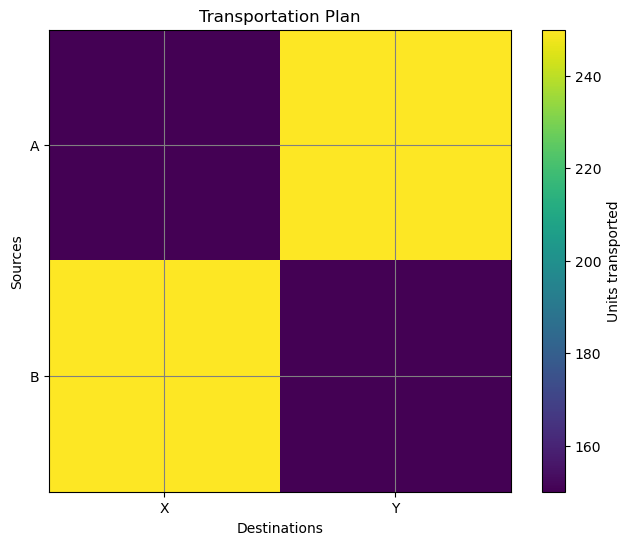

In [26]:
plot_transportation_plan(optimal_solution)

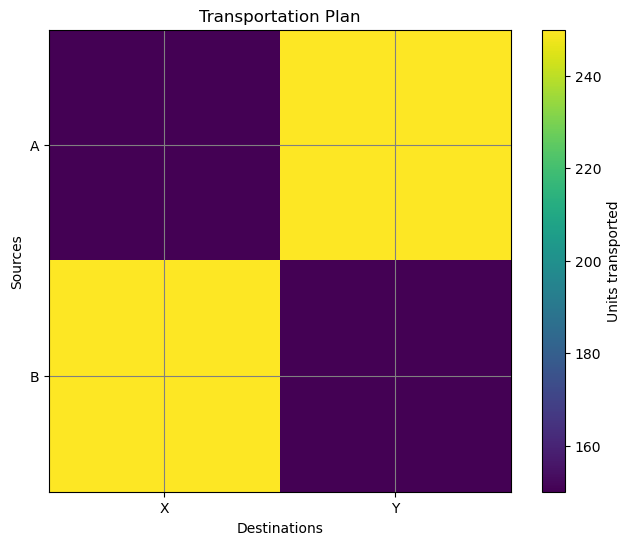

In [27]:
plot_transportation_plan(optimal_solution1)